# Clase 01: Conceptos básicos de NLP

Instalar y cargar las librerías como sigue a continuación: 

In [23]:
# si no tiene alguna librería, ejecutar en un bloque lo siguiente:
# !pip install -U nombre_libreria

import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
from tqdm.auto import tqdm
import csv
import os
import emoji

# Dataset

Usaremos un dataset de mensajes de odio en español alojado en <https://zenodo.org/record/2592149#.Ystdn3bMKUl>

In [6]:
cwd = os.getcwd()
print(os.path.join(cwd, "labeled_corpus_6K.txt"))

/Users/hernan/dev/MTI-455/notebooks/labeled_corpus_6K.txt


In [7]:
df = pd.read_csv(os.path.join(cwd, "labeled_corpus_6K.txt"),
                         sep = "\t", 
                         encoding = "utf8",
                         quotechar = "\"",
                         names=['id', 'text', 'class'], 
                         header=None) 

In [8]:
df.head(5)

,id,text,class
0,828025263321657348,Ismael es egocentrico porque se vuelve loca si...,0
1,828025128797741057,..ya tardaba en salir quien pronunciase nombre...,0
2,828025087815274496,"(Esto no es un discurso político y razonado, o...",0
3,828025006626058241,"Muy despreciados,siiii,pero todos vestidos de ...",1
4,828024709761658880,marica explicame porque a veces no te entiendo...,1


# Pre-procesamos el texto

Utilizaremos un archivo llamado ``preprocessing_tweets.py`` que contiene diversas funciones para limpiar el texto.



In [9]:
# todo a minúscula.
from preprocessing_tweets import *
df['text_prepro'] = df['text'].str.lower()

In [10]:
df.head()

,id,text,class,text_prepro
0,828025263321657348,Ismael es egocentrico porque se vuelve loca si...,0,ismael es egocentrico porque se vuelve loca si...
1,828025128797741057,..ya tardaba en salir quien pronunciase nombre...,0,..ya tardaba en salir quien pronunciase nombre...
2,828025087815274496,"(Esto no es un discurso político y razonado, o...",0,"(esto no es un discurso político y razonado, o..."
3,828025006626058241,"Muy despreciados,siiii,pero todos vestidos de ...",1,"muy despreciados,siiii,pero todos vestidos de ..."
4,828024709761658880,marica explicame porque a veces no te entiendo...,1,marica explicame porque a veces no te entiendo...


Eliminamos menciones de URL

In [11]:
# eliminamos urls
tqdm.pandas()
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_mentions_urls(text))

100%|██████████| 5938/5938 [00:00<00:00, 151866.35it/s]


In [12]:
# eliminamos hashtags
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_hts(text))

100%|██████████| 5938/5938 [00:00<00:00, 186824.62it/s]


In [13]:
# eliminamos puntuacion
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_punctuation(text))

100%|██████████| 5938/5938 [00:00<00:00, 66880.72it/s]


In [14]:
# eliminamos numeros
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_numbers(text))

100%|██████████| 5938/5938 [00:00<00:00, 160316.29it/s]


In [15]:
# eliminamos tildes
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_accents(text))

100%|██████████| 5938/5938 [00:00<00:00, 505999.01it/s]


In [24]:
# eliminamos stopwords
stopwords = create_stopwords()
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_stopwords(text, stopwords))

100%|██████████| 5938/5938 [00:00<00:00, 186812.01it/s]


In [25]:
df['text_prepro'] = df['text_prepro'].progress_apply(lambda text: remove_dots(text))

100%|██████████| 5938/5938 [00:00<00:00, 325102.50it/s]


In [26]:
df.head()

,id,text,class,text_prepro
0,828025263321657348,Ismael es egocentrico porque se vuelve loca si...,0,ismael egocentrico vuelve loca pelo bonito😂😂😂😂...
1,828025128797741057,..ya tardaba en salir quien pronunciase nombre...,0,tardaba salir pronunciase nombre catalan silab...
2,828025087815274496,"(Esto no es un discurso político y razonado, o...",0,discurso politico razonado obviamente llamada ...
3,828025006626058241,"Muy despreciados,siiii,pero todos vestidos de ...",1,despreciados siiii vestidos alta costura españ...
4,828024709761658880,marica explicame porque a veces no te entiendo...,1,marica explicame entiendo — venir ensuciar cc ...


# Tokenizar el texto

In [28]:
df['tokenized_text'] = df.progress_apply(lambda row: nltk.word_tokenize(row['text_prepro']), axis=1)

100%|██████████| 5938/5938 [00:00<00:00, 9249.09it/s]


In [29]:
df.head()

,id,text,class,text_prepro,tokenized_text
0,828025263321657348,Ismael es egocentrico porque se vuelve loca si...,0,ismael egocentrico vuelve loca pelo bonito😂😂😂😂...,"[ismael, egocentrico, vuelve, loca, pelo, boni..."
1,828025128797741057,..ya tardaba en salir quien pronunciase nombre...,0,tardaba salir pronunciase nombre catalan silab...,"[tardaba, salir, pronunciase, nombre, catalan,..."
2,828025087815274496,"(Esto no es un discurso político y razonado, o...",0,discurso politico razonado obviamente llamada ...,"[discurso, politico, razonado, obviamente, lla..."
3,828025006626058241,"Muy despreciados,siiii,pero todos vestidos de ...",1,despreciados siiii vestidos alta costura españ...,"[despreciados, siiii, vestidos, alta, costura,..."
4,828024709761658880,marica explicame porque a veces no te entiendo...,1,marica explicame entiendo — venir ensuciar cc ...,"[marica, explicame, entiendo, —, venir, ensuci..."


In [32]:
df.iloc[0]['tokenized_text']

['ismael',
 'egocentrico',
 'vuelve',
 'loca',
 'pelo',
 'bonito😂😂😂😂',
 'define',
 'objetivo']

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
vect = CountVectorizer()  
vects = vect.fit_transform(df.text_prepro)

In [35]:
vects

<5938x12916 sparse matrix of type '<class 'numpy.int64'>'
	with 41466 stored elements in Compressed Sparse Row format>

In [53]:
td = pd.DataFrame(vects.todense())
td.columns = vect.get_feature_names()
term_document_matrix = td.T
term_document_matrix.columns = ['Doc'+str(i) for i in range(1, td.shape[0]+1)]
term_document_matrix['total_count'] = term_document_matrix.sum(axis=1)

# Top 25 words 
term_document_matrix = term_document_matrix.sort_values(by ='total_count',ascending=False)

# Print the first 10 rows 
print(term_document_matrix.head(10))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                 Doc1  Doc2  Doc3  Doc4  Doc5  Doc6  Doc7  Doc8  Doc9  Doc10  \
subnormal           0     0     0     0     0     0     0     0     0      0   
independentista     0     0     0     0     0     0     0     0     0      0   
fascista            0     0     0     0     0     0     0     0     0      0   
facha               0     0     0     0     0     0     0     0     0      0   
mierda              0     0     0     0     0     0     0     0     0      0   
fascistas           0     0     0     0     0     0     0     0     0      0   
fachas              0     0     0     0     0     0     0     0     0      0   
puta                0     0     0     0     0     0     0     0     0      0   
puto                0     0     0     0     0     0     0     0     0      0   
maricon             0     0     0     0     0     0     0     0     1      0   

                 ...  Doc5930  Doc5931  Doc5932  Doc5933  Doc5934  Doc5935  \
subnormal        ...        0        0   

<AxesSubplot:>

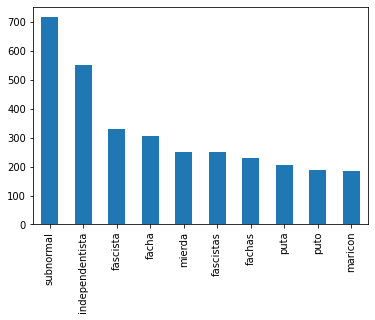

In [54]:
term_document_matrix['total_count'].head(10).plot.bar()


In [36]:
td = pd.DataFrame(vects.todense()).iloc[:5]  
td.columns = vect.get_feature_names()
term_document_matrix = td.T
term_document_matrix.columns = ['Doc'+str(i) for i in range(1, td.shape[0]+1)]
term_document_matrix['total_count'] = term_document_matrix.sum(axis=1)

# Top 25 words 
term_document_matrix = term_document_matrix.sort_values(by ='total_count',ascending=False)[:25] 

# Print the first 10 rows 
print(term_document_matrix.drop(columns=['total_count']).head(10))

            Doc 1  Doc 2  Doc 3  Doc 4  Doc 5
salir           0      1      0      0      0
atencion        0      0      1      0      0
cuesta          0      0      1      0      0
loca            1      0      0      0      0
joder           0      0      1      0      0
obviamente      0      0      1      0      0
eduaaard        0      1      0      0      0
ensuciar        0      0      0      0      1
explicame       0      0      0      0      1
plana           0      1      0      0      0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
